In [60]:
import sys, os
sys.path.append(os.path.abspath("/Users/DavidHolzwarth/Uni/EPFL/bachelors-thesis"))

import time
import matplotlib.pyplot as plt

import LE as le
import LP as lp
import iterative as iterative
import graph_viz as viz
import logger_creator

import graph_tools
import networkx as nx

def generate_confidence_delegation_graph(n, seed=0):
    """
    Generate a directed graph with a pyramid structure of lots of low confidence nodes, 
    fewer medium confidence nodes, and the fewest high confidence nodes. This simulates a
    scenario where most nodes have low confidence, some have medium, and very few have high confidence
    with a tendency to delegate upwards."""

    if n == 0:
        return nx.DiGraph()

    # Allocate nodes in a pyramid: many low, fewer medium, fewest high confidence
    low_count = int(n * 0.6)
    medium_count = int(n * 0.3)
    high_count = n - low_count - medium_count
    sizes = [low_count, medium_count, high_count]

    p_down = 0.05
    p_same = 0.10
    p_up = 1

    # Delegation tendency matrix: rows = from group, cols = to group
    # Higher values for upward delegation

    # Probabilities from Low
    p_ll = p_same / low_count                                if low_count > 0 else 1
    p_lm = p_up   / ((low_count * medium_count) ** 0.5)      if low_count > 0 and medium_count > 0 else 1
    p_lh = p_up   / ((low_count * high_count)  ** 0.5)       if low_count > 0 and high_count  > 0 else 1

    # Probabilities from Medium 
    p_ml = p_down / ((medium_count * low_count)  ** 0.5)     if medium_count > 0 and low_count  > 0 else 1
    p_mm = p_same / medium_count                             if medium_count > 0 else 1
    p_mh = p_up   / ((medium_count * high_count) ** 0.5)     if medium_count > 0 and high_count  > 0 else 1

    # Probabilities from High 
    p_hl = p_down / ((high_count  * low_count)  ** 0.5)      if high_count  > 0 and low_count  > 0 else 1
    p_hm = p_down / ((high_count  * medium_count) ** 0.5)    if high_count  > 0 and medium_count > 0 else 1
    p_hh = p_same / high_count                               if high_count  > 0 else 1

    # Assemble into matrix
    p = [
        [p_ll, p_lm, p_lh],  # From Low
        [p_ml, p_mm, p_mh],  # From Medium
        [p_hl, p_hm, p_hh],  # From High
    ]

    G = nx.stochastic_block_model(sizes, p, directed=True, seed=seed)

    return G


In [63]:
# to guage how often cycles appear in these graphs
for seed in range(10):
    i_s = []
    for i in range(100):
        stochastic_block_model_graph = generate_confidence_delegation_graph(i, seed=seed)
        stochastic_block_model_graph = graph_tools.nx_graph_nodes_to_str(stochastic_block_model_graph)
        delegation_graph = graph_tools.prepare_graph(stochastic_block_model_graph.nodes(), stochastic_block_model_graph.edges(), 0.0)
        if "lost" in delegation_graph:
            i_s.append(i)
    if i_s:
        print(f"Seed {seed}: {i_s}")


Seed 0: [14, 29, 32, 39, 63, 86, 87]
Seed 1: [10, 12, 14, 51, 76, 87]
Seed 2: [5, 6, 10, 33, 42, 89, 98]
Seed 3: [4, 9, 24, 28, 62]
Seed 4: [5, 20, 28, 33, 34, 38, 43, 44, 60, 74, 83]
Seed 5: [9, 27, 43, 56, 91, 92, 93]
Seed 6: [67]
Seed 7: [19, 26, 85, 97]
Seed 8: [84]
Seed 9: [71]


In [62]:
stochastic_block_model_graph = generate_confidence_delegation_graph(20, seed=1)
stochastic_block_model_graph = graph_tools.nx_graph_nodes_to_str(stochastic_block_model_graph)
delegations_orig = graph_tools.nx_graph_to_dict(stochastic_block_model_graph)

viz.visualize_delegation_graph(delegations_orig)

print(list(nx.strongly_connected_components(stochastic_block_model_graph)))

Parsing the data...Done
Parsing the data...Done


Address already in use
Port 8050 is in use by another program. Either identify and stop that program, or start the server with a different port.


Graph visualization failed because no ports were found or there was another error.
[{'17'}, {'0'}, {'18'}, {'14'}, {'3'}, {'1'}, {'2'}, {'4'}, {'16'}, {'5', '13'}, {'6'}, {'7'}, {'15'}, {'8'}, {'9'}, {'10'}, {'11'}, {'12'}, {'19'}]


No trigger


0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000


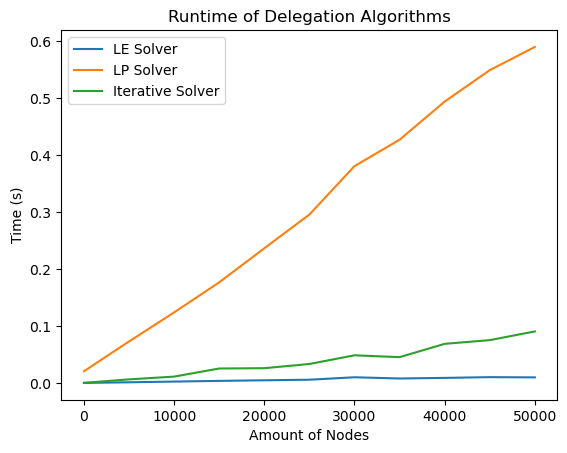

In [ ]:
range_x = range(0, 50001, 5000)

time_data_le = []
time_data_lp = []
time_data_iterative = []
cycles = []


logger, handler = logger_creator.create_logger("benchmarking")

for num_loops in range(1):
    times_le = []
    times_lp = []
    times_iterative = []

    for num_nodes in range_x:
        print(num_nodes)

        stochastic_block_model_graph = generate_confidence_delegation_graph(num_nodes)
        stochastic_block_model_graph = graph_tools.nx_graph_nodes_to_str(stochastic_block_model_graph)
        delegation_graph = graph_tools.prepare_graph(stochastic_block_model_graph.nodes(), stochastic_block_model_graph.edges(), 0.0)
        nodes = list(delegation_graph)
        delegations_orig = graph_tools.nx_graph_to_dict(delegation_graph)
        delegations = graph_tools.invert_graph(delegations_orig)

        # Verify the solutions are equal
        powers_le, sinks_le = le.resolve_delegations(delegations, nodes)
        powers_lp, sinks_lp = lp.resolve_delegations(delegations, nodes)
        powers_iter = iterative.iterate_delegations(delegations, nodes)

        if powers_le.keys() != powers_lp.keys() or any(abs(powers_le[k] - powers_lp[k]) > 10**-6 for k in powers_le):
            logger.error("Powers do not match")
            logger.error(f"LE: {powers_le}")
            logger.error(f"LP: {powers_lp}")
            print("Mismatching powers in LE and LP. Check the log file for details.")
            break

        for node in sinks_le:
            if (powers_lp[node] - powers_iter[node] < 0.01):
                continue
            else: 
                logger.error("Powers do not match")
                logger.error(f"LP: {powers_lp}")
                logger.error(f"Iterative: {powers_iter}")
                print("Mismatching powers in LP and Iterative. Check the log file for details.")
                break

        n = 10
        if 0 <= num_nodes < 500:
            n = 100
        elif 500 <= num_nodes < 2000:
            n = 50

        # LE
        le_model = le.set_up(delegations, nodes)
        start_time = time.time()
        for _ in range(n):
            le.solve(*le_model)
        end_time = time.time()
        
        times_le.append((end_time - start_time) / n)

        # LP
        lp_model = lp.set_up(delegations, nodes)
        start_time = time.time()
        for _ in range(n):
            lp.solve(*lp_model)
        end_time = time.time()

        times_lp.append((end_time - start_time) / n)
    
        # Iterative
        start_time = time.time()
        for _ in range(n):
            p = iterative.iterate_delegations(delegations, nodes)
        end_time = time.time()

        times_iterative.append((end_time - start_time) / n)


    time_data_le.append(times_le)
    time_data_lp.append(times_lp)
    time_data_iterative.append(times_iterative)

logger.removeHandler(handler)
handler.close()

x = list(range_x)

plt.clf()

for i in range(len(time_data_lp)):
    plt.plot(x, time_data_le[i], label=f"LE Solver")
    plt.plot(x, time_data_lp[i], label=f"LP Solver") 
    plt.plot(x, time_data_iterative[i], label=f"Iterative Solver")  

plt.legend()
plt.xlabel("Amount of Nodes")
plt.ylabel("Time (s)")
plt.title("Runtime of Delegation Algorithms")
plt.show()

In [ ]:
print(x)
print("time_data_iterative")
print(time_data_iterative)
print("time_data_le")
print(time_data_le)
print("time_data_lp")
print(time_data_lp)

starting 0
starting 5000
starting 10000
starting 15000
starting 20000
starting 25000
starting 30000
starting 35000
starting 40000
starting 45000
starting 50000


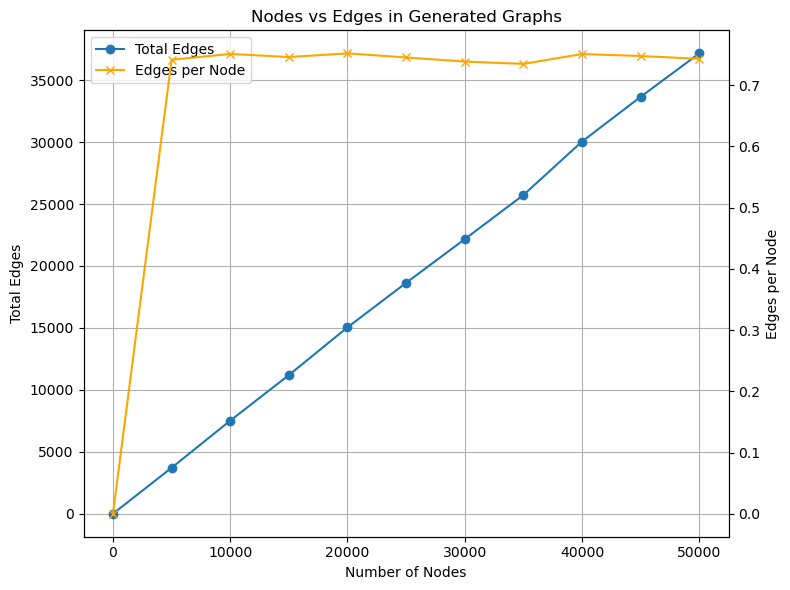

In [50]:
import matplotlib.pyplot as plt
import networkx as nx

def generate_graph(num_nodes):
    stochastic_block_model_graph = generate_confidence_delegation_graph(num_nodes)
    stochastic_block_model_graph = graph_tools.nx_graph_nodes_to_str(stochastic_block_model_graph)
    return graph_tools.prepare_graph(stochastic_block_model_graph.nodes(), stochastic_block_model_graph.edges(), 0.0)

node_counts = []
edge_counts = []
edges_per_node_counts = []

for i in range(0, 50001, 5000): 
    print("starting", i)
    G = generate_graph(i)
    node_counts.append(G.number_of_nodes())
    edge_counts.append(G.number_of_edges())
    edges_per_node_counts.append(G.number_of_edges() / G.number_of_nodes() if G.number_of_nodes() > 0 else 0)

fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot total edges on the left y-axis
ax1.plot(node_counts, edge_counts, marker='o', label='Total Edges')
ax1.set_xlabel("Number of Nodes")
ax1.set_ylabel("Total Edges")
ax1.tick_params(axis='y')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
ax2.plot(node_counts, edges_per_node_counts, marker='x', label='Edges per Node', color='orange')
ax2.set_ylabel("Edges per Node")
ax2.tick_params(axis='y')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title("Nodes vs Edges in Generated Graphs")
ax1.grid(True)
fig.tight_layout()
plt.show()
